In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.plot import plot_summary_stats
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Clear jupyter notebook default handler
default_logger = logging.getLogger()
default_logger.handlers.clear()

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

12:02:51 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
12:02:51 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
12:02:51 - mcmc.system | INFO: Initializing 64 virtual atoms
12:02:51 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12:02:51 - mcmc.system | INFO: Number of pristine atoms is 60
12:02:51 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
12:02:51 - mcmc

      Step     Time          Energy         fmax
BFGS:    0 12:02:52     -467.521881        0.2044
BFGS:    1 12:02:52     -467.525757        0.1803
BFGS:    2 12:02:52     -467.540619        0.0793
BFGS:    3 12:02:52     -467.540924        0.0598
BFGS:    4 12:02:52     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

12:02:52 - mcmc.mcmc | INFO: Using run folder SrTiO3(001)
12:02:52 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
12:02:52 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
12:02:52 - mcmc.mcmc | INFO: Starting with iteration 0
12:02:52 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
12:02:52 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:02:53     -458.632050       37.3936
BFGS:    1 12:02:53     -464.311279       16.4727
BFGS:    2 12:02:53     -466.514557        8.0537
BFGS:    3 12:02:53     -467.660797        3.5488
BFGS:    4 12:02:53     -468.245697        2.9305
BFGS:    5 12:02:53     -468.612213        1.3832
BFGS:    6 12:02:53     -468.672974        1.4256
BFGS:    7 12:02:53     -468.888794        1.6837
BFGS:    8 12:02:54     -468.983765        1.3075
BFGS:    9 12:02:54     -469.052368        0.8546
BFGS:   10 12:02:54     -469.089355        0.9229
BFGS:   11 12:02:54     -469.138275        0.8548
BFGS:   12 12:02:54     -469.170746        0.7381
BFGS:   13 12:02:54     -469.210297        0.6431
BFGS:   14 12:02:54     -469.236786        0.4049
BFGS:   15 12:02:54     -469.252716        0.2335
BFGS:   16 12:02:54     -469.258331        0.1935
BFGS:   17 12:02:55     -469.261383        0.1708
BFGS:   18 12:02:55     -469.264893        0.1319
B

12:03:04 - mcmc.system | INFO: Optimized structure has Energy = 12.471
12:03:04 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:04     -469.796967        1.3103
BFGS:    1 12:03:04     -469.864166        1.3226
BFGS:    2 12:03:04     -470.125641        1.8126
BFGS:    3 12:03:04     -470.199371        1.0502
BFGS:    4 12:03:05     -470.288116        0.7072
BFGS:    5 12:03:05     -470.318451        0.4976
BFGS:    6 12:03:05     -470.327148        0.3768
BFGS:    7 12:03:05     -470.343506        0.2061
BFGS:    8 12:03:05     -470.346802        0.2019
BFGS:    9 12:03:05     -470.351349        0.2450
BFGS:   10 12:03:05     -470.356110        0.2296
BFGS:   11 12:03:05     -470.359772        0.1566
BFGS:   12 12:03:05     -470.362274        0.1405
BFGS:   13 12:03:05     -470.363800        0.0788
BFGS:   14 12:03:05     -470.364716        0.0770
BFGS:   15 12:03:06     -470.365753        0.0914
BFGS:   16 12:03:06     -470.366730        0.1024
BFGS:   17 12:03:06     -470.367889        0.1103
BFGS:   18 12:03:06     -470.368774        0.0742
B

12:03:13 - mcmc.system | INFO: Optimized structure has Energy = 12.737
12:03:13 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:13     -471.023163       11.7664
BFGS:    1 12:03:13     -473.895660        7.5880
BFGS:    2 12:03:13     -475.873871        4.1574
BFGS:    3 12:03:13     -477.037964        1.6558
BFGS:    4 12:03:14     -477.644775        1.2749
BFGS:    5 12:03:14     -478.066803        3.1535
BFGS:    6 12:03:14     -478.292877        1.5596
BFGS:    7 12:03:14     -479.033447        1.3664
BFGS:    8 12:03:14     -479.396332        2.0466
BFGS:    9 12:03:14     -479.654541        2.0094
BFGS:   10 12:03:14     -480.122528        1.8922
BFGS:   11 12:03:14     -480.435333        1.7323
BFGS:   12 12:03:14     -480.819611        2.0569
BFGS:   13 12:03:14     -480.949677        2.4160
BFGS:   14 12:03:15     -481.097656        1.9162
BFGS:   15 12:03:15     -481.262695        1.7204
BFGS:   16 12:03:15     -481.584747        1.4406
BFGS:   17 12:03:15     -481.696167        1.4829
BFGS:   18 12:03:15     -481.774139        1.2025
B

12:03:23 - mcmc.system | INFO: Optimized structure has Energy = 11.522
12:03:23 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:23     -465.689972       33.0076
BFGS:    1 12:03:23     -473.889984       14.9761
BFGS:    2 12:03:23     -478.552582        8.5219
BFGS:    3 12:03:24     -481.376831        4.7579
BFGS:    4 12:03:24     -483.116119        2.9848
BFGS:    5 12:03:24     -483.976898        3.1207
BFGS:    6 12:03:24     -484.477539        2.9678
BFGS:    7 12:03:24     -485.433838        2.3838
BFGS:    8 12:03:24     -486.330902        3.7392
BFGS:    9 12:03:24     -487.408203        4.9799
BFGS:   10 12:03:24     -488.047607        3.2833
BFGS:   11 12:03:24     -488.729004        2.1967
BFGS:   12 12:03:24     -489.135956        1.9595
BFGS:   13 12:03:24     -489.942383        2.0355
BFGS:   14 12:03:25     -490.203766        1.7693
BFGS:   15 12:03:25     -490.700104        1.1118
BFGS:   16 12:03:25     -490.882355        2.4263
BFGS:   17 12:03:25     -491.087372        1.5578
BFGS:   18 12:03:25     -491.300873        1.4472
B

12:03:34 - mcmc.system | INFO: Optimized structure has Energy = 8.537
12:03:34 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:34    34307.187500   814934.9372
BFGS:    1 12:03:34     -430.561035      415.4089
BFGS:    2 12:03:34     -445.976654      400.4861
BFGS:    3 12:03:34     -466.364746       71.6212
BFGS:    4 12:03:34     -465.180328      197.4549
BFGS:    5 12:03:34     -472.596680       50.4904
BFGS:    6 12:03:34     -474.621582       68.5434
BFGS:    7 12:03:34     -468.387238      201.2675
BFGS:    8 12:03:35     -477.549896       15.9150
BFGS:    9 12:03:35     -479.204315       24.6874
BFGS:   10 12:03:35     -481.403473        7.3448
BFGS:   11 12:03:35     -483.432098       27.0487
BFGS:   12 12:03:35     -484.068756       52.6000
BFGS:   13 12:03:35     -486.186188       34.3735
BFGS:   14 12:03:35     -487.467255        4.8750
BFGS:   15 12:03:35     -488.149628        3.1463
BFGS:   16 12:03:35     -488.484497        3.2952
BFGS:   17 12:03:35     -488.837250        8.9208
BFGS:   18 12:03:35     -489.393158        4.5765
B

12:03:44 - mcmc.system | INFO: Optimized structure has Energy = 8.622
12:03:44 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:44     -467.128784       37.3097
BFGS:    1 12:03:44     -482.868652       18.7991
BFGS:    2 12:03:44     -491.600677       10.4004
BFGS:    3 12:03:45     -496.963715        6.8217
BFGS:    4 12:03:45     -500.142181        4.9162
BFGS:    5 12:03:45     -502.022552        3.9645
BFGS:    6 12:03:45     -503.111694        2.7761
BFGS:    7 12:03:45     -503.800446        2.2058
BFGS:    8 12:03:45     -504.409149        2.3101
BFGS:    9 12:03:45     -504.761322        1.3161
BFGS:   10 12:03:45     -505.124359        1.3423
BFGS:   11 12:03:45     -505.285675        1.2114
BFGS:   12 12:03:45     -505.465576        1.2576
BFGS:   13 12:03:45     -505.627197        1.2417
BFGS:   14 12:03:46     -505.784210        0.9946
BFGS:   15 12:03:46     -505.918854        0.8585
BFGS:   16 12:03:46     -506.035156        0.6095
BFGS:   17 12:03:46     -506.137207        0.6464
BFGS:   18 12:03:46     -506.225067        0.5580
B

12:03:55 - mcmc.system | INFO: Optimized structure has Energy = 9.560
12:03:55 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:03:55     -343.483795      195.8126
BFGS:    1 12:03:55     -414.363373      113.6717
BFGS:    2 12:03:55     -445.556122       70.7609
BFGS:    3 12:03:55     -466.835297       50.3562
BFGS:    4 12:03:55     -483.287506       31.7581
BFGS:    5 12:03:55     -494.927765       20.0229
BFGS:    6 12:03:55     -501.402435       13.3369
BFGS:    7 12:03:55     -505.750214        9.5793
BFGS:    8 12:03:55     -508.544586        6.6791
BFGS:    9 12:03:55     -510.670654        4.7601
BFGS:   10 12:03:56     -512.250244        3.0156
BFGS:   11 12:03:56     -513.796204        5.1112
BFGS:   12 12:03:56     -515.506958        3.6199
BFGS:   13 12:03:56     -517.145020        5.0324
BFGS:   14 12:03:56     -518.126953        6.5013
BFGS:   15 12:03:56     -519.143982        2.6878
BFGS:   16 12:03:56     -519.881653        2.1587
BFGS:   17 12:03:56     -520.612366        1.7789
BFGS:   18 12:03:56     -520.932373        1.9079
B

12:04:05 - mcmc.system | INFO: Optimized structure has Energy = 6.496
12:04:05 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:04:05    34481.308594   814790.3316
BFGS:    1 12:04:05     -249.867859      560.6125
BFGS:    2 12:04:05     -325.818878      415.8892
BFGS:    3 12:04:05     -371.113739       84.3400
BFGS:    4 12:04:05     -415.615143       33.6632
BFGS:    5 12:04:05     -434.495392       30.7658
BFGS:    6 12:04:05     -443.904388      105.6642
BFGS:    7 12:04:05     -454.089508       40.1637
BFGS:    8 12:04:06     -457.534271      100.4587
BFGS:    9 12:04:06     -462.928467       80.4984
BFGS:   10 12:04:06     -464.958984       74.8958
BFGS:   11 12:04:06     -468.750244       23.5201
BFGS:   12 12:04:06     -468.254425      196.8357
BFGS:   13 12:04:06     -472.246185       61.7557
BFGS:   14 12:04:06     -472.729248       93.5545
BFGS:   15 12:04:06     -475.653900       32.9611
BFGS:   16 12:04:06     -476.927368       26.4290
BFGS:   17 12:04:06     -478.042725       59.1107
BFGS:   18 12:04:06     -478.949615       82.2697
B

12:04:15 - mcmc.system | INFO: Optimized structure has Energy = 5.678
12:04:15 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:04:15     -342.961517      200.1715
BFGS:    1 12:04:15     -420.486969      111.6602
BFGS:    2 12:04:15     -451.630280       73.1984
BFGS:    3 12:04:15     -471.273926       51.3488
BFGS:    4 12:04:15     -486.368561       32.8455
BFGS:    5 12:04:15     -497.650116       19.7807
BFGS:    6 12:04:16     -504.895905       11.8887
BFGS:    7 12:04:16     -509.959259        7.7887
BFGS:    8 12:04:16     -513.613525        5.4481
BFGS:    9 12:04:16     -516.334351        4.0196
BFGS:   10 12:04:16     -518.172119        3.6763
BFGS:   11 12:04:16     -519.481079        3.3139
BFGS:   12 12:04:16     -520.835876        2.6162
BFGS:   13 12:04:16     -521.725037        2.5561
BFGS:   14 12:04:16     -522.288330        2.3330
BFGS:   15 12:04:16     -522.741882        1.5138
BFGS:   16 12:04:16     -523.045715        1.3453
BFGS:   17 12:04:17     -523.655762        1.6556
BFGS:   18 12:04:17     -524.036133        1.9625
B

12:04:25 - mcmc.system | INFO: Optimized structure has Energy = 3.877
12:04:25 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:04:25     -362.715790      134.4223
BFGS:    1 12:04:25     -426.830078       71.8397
BFGS:    2 12:04:25     -454.576538       48.9189
BFGS:    3 12:04:25     -470.344757       37.6454
BFGS:    4 12:04:26     -486.522064       20.1401
BFGS:    5 12:04:26     -497.718842       13.5836
BFGS:    6 12:04:26     -505.013184        8.1926
BFGS:    7 12:04:26     -509.592499        5.3259
BFGS:    8 12:04:26     -512.664734        3.6750
BFGS:    9 12:04:26     -514.945007        3.1576
BFGS:   10 12:04:26     -516.793213        3.2768
BFGS:   11 12:04:26     -518.287781        3.5850
BFGS:   12 12:04:26     -519.655029        3.8351
BFGS:   13 12:04:26     -520.888794        3.6225
BFGS:   14 12:04:26     -522.445618        3.7613
BFGS:   15 12:04:26     -523.687317        5.6246
BFGS:   16 12:04:27     -524.565979        3.1564
BFGS:   17 12:04:27     -525.316101        1.8106
BFGS:   18 12:04:27     -525.647949        1.5302
B

12:04:35 - mcmc.system | INFO: Optimized structure has Energy = -2.877


Time taken = 102.602 seconds


Plot results

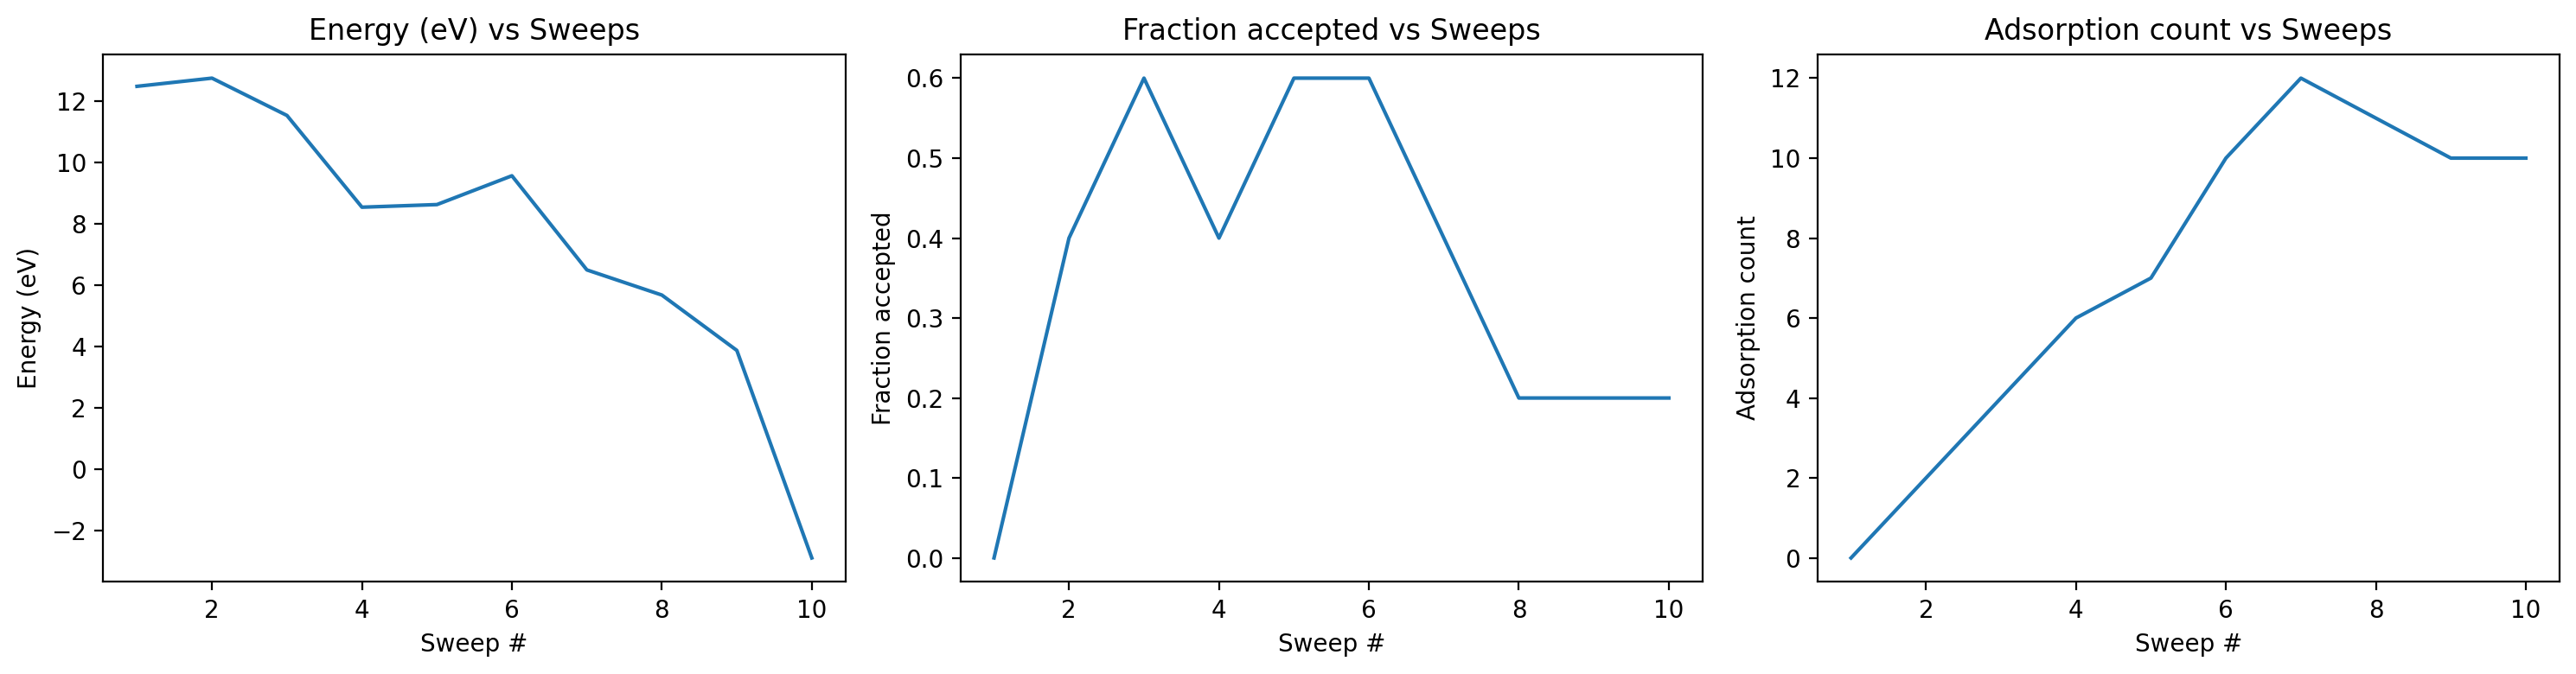

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)